# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
pydot.find_graphviz()

{'dot': 'C:\\Program Files\\Graphviz\\bin\\dot.exe',
 'twopi': 'C:\\Program Files\\Graphviz\\bin\\twopi.exe',
 'neato': 'C:\\Program Files\\Graphviz\\bin\\neato.exe',
 'circo': 'C:\\Program Files\\Graphviz\\bin\\circo.exe',
 'fdp': 'C:\\Program Files\\Graphviz\\bin\\fdp.exe',
 'sfdp': 'C:\\Program Files\\Graphviz\\bin\\sfdp.exe'}

In [4]:
import pandas as pd
global df
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [5]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [6]:
from keras import backend as K
from math import sqrt 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [7]:
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [9]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [10]:
test_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
87370,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0
87372,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0
87373,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0


In [11]:
global train_dataframe
global test_dataframe

category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

Q1a) Why is this done instead of using random train/test split

**The rationale to predict resale prices is to used past data as the training dataset to predict future values.**


In [12]:
global month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_years, degree_centrality, eigenvector_centrality, dist_to_nearest_stn, dist_to_dhoby
global month_encoded, storey_range_encoded, flat_model_type_encoded, floor_area_sqm_encoded, remaining_lease_year_encoded, degree_centrality_encoded, eigenvector_centrality_encoded, dist_to_nearest_stn_encoded, dist_to_dhoby_encoded

In [13]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
#resale_price = keras.Input(shape=(1,), name="resale_price")

all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]


#Integer categorical features
month_encoded = encode_categorical_feature(month, "month",train_ds, False)

#String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range",train_ds, True)

#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)

all_features = layers.Concatenate()(
                [
                    month_encoded,
                    storey_range_encoded,
                    flat_model_type_encoded,
                    floor_area_sqm_encoded,
                    remaining_lease_year_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded
                ]
)
output = layers.Dense(1, activation="linear")(all_features)
adam_model = keras.Model(all_inputs, output)
adam_model.compile(optimizer="adam", loss= "mse",metrics=[r2])


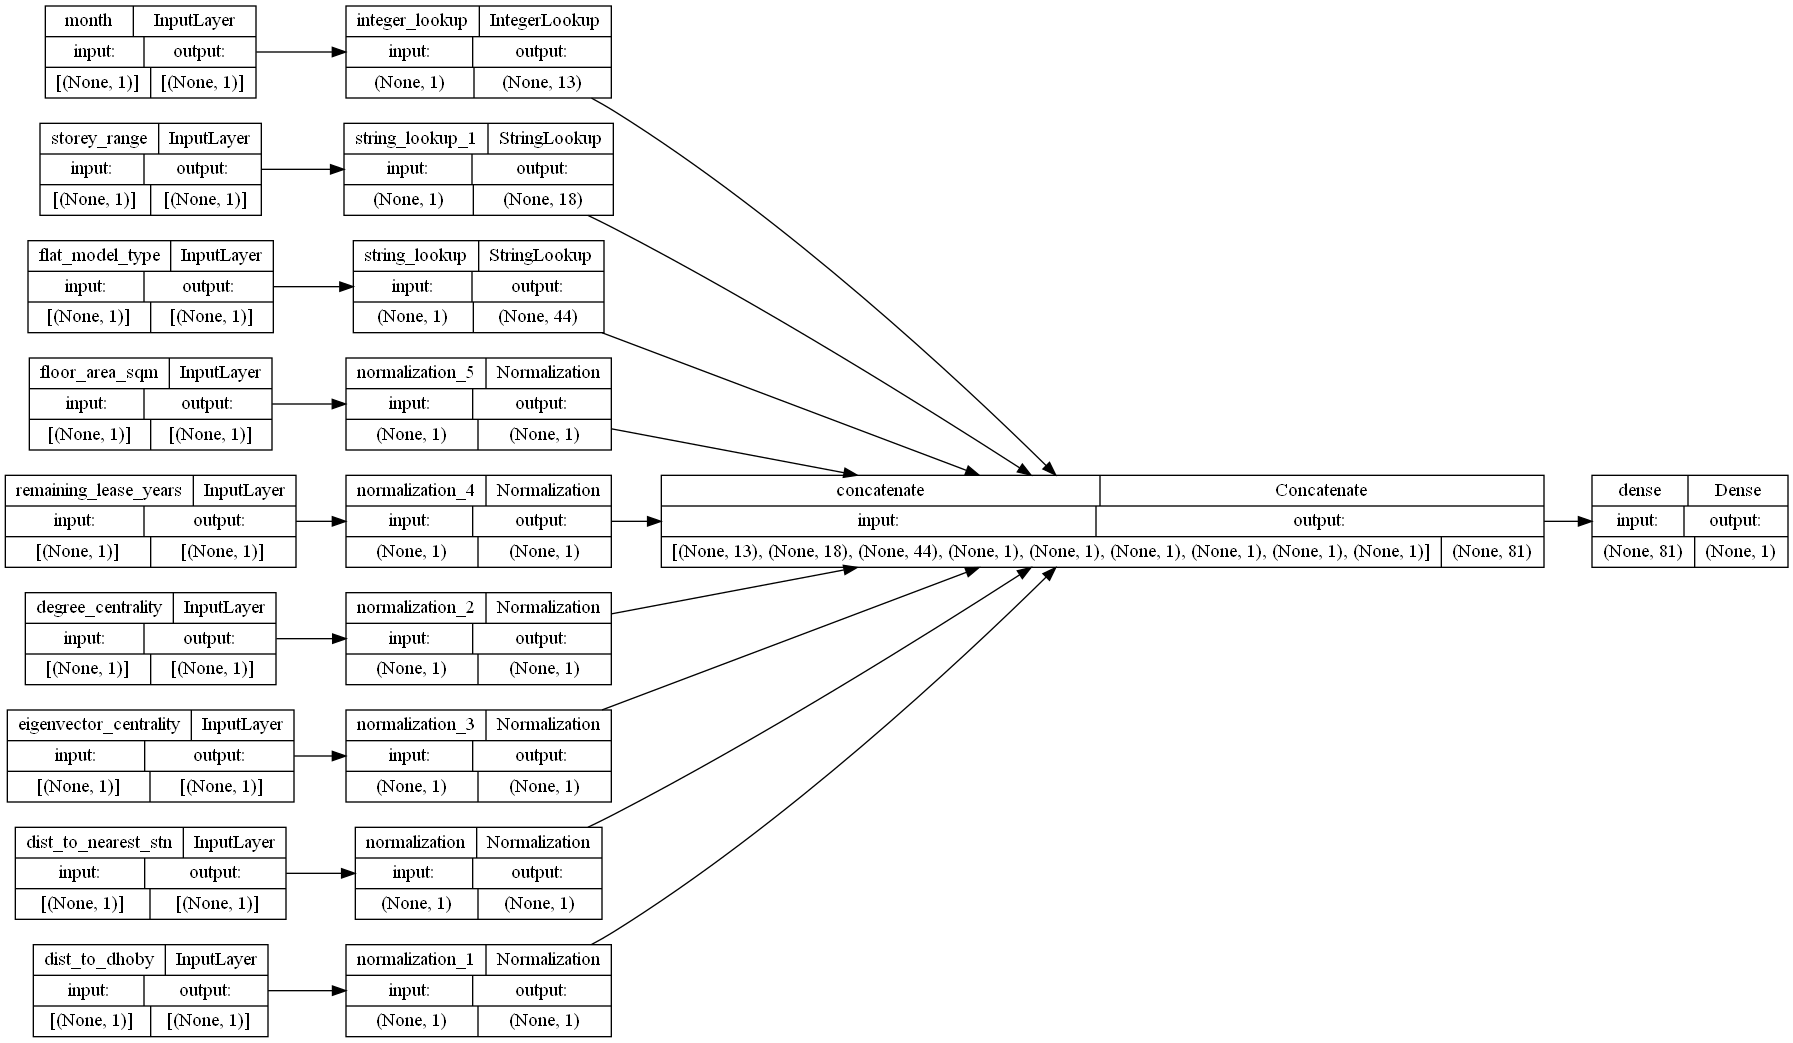

In [14]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(adam_model, show_shapes=True, rankdir="LR")

Q1C) Training **Adam** model and SGD model 

In [15]:
history = {}
no_epochs = 50
batch_size = 256
history["adam_model"] = adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 6s 10ms/step - loss: 219585921024.0000 - r2: -8.3474 - val_loss: 301486735360.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 4s 9ms/step - loss: 219584561152.0000 - r2: -8.3520 - val_loss: 301485064192.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 4s 10ms/step - loss: 219583217664.0000 - r2: -8.3501 - val_loss: 301483458560.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 4s 9ms/step - loss: 219581890560.0000 - r2: -8.3437 - val_loss: 301481951232.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 4s 9ms/step - loss: 219580661760.0000 - r2: -8.3458 - val_loss: 301480378368.0000 - val_r2: -10.1214
Epoch 6/50
342/342 [==============================] - 4s 9ms/step - loss: 219579383808.0000 - r2: -8.3513 - val_loss: 301478871040.0000 - val_r2: -10.0838
Epoch 7/50
342/342 [==============================] - 4s 9ms/step - loss: 21957

Training of **SGD model** with learning rate **0.01**

In [16]:
custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
sgd_model = keras.Model(all_inputs, output)
sgd_model.compile(optimizer=custom_optimizer, loss="mse", metrics=[r2])
history["sgd_model"] = sgd_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=2)

Epoch 1/50
342/342 - 4s - loss: 18724683776.0000 - r2: 0.1967 - val_loss: 13789810688.0000 - val_r2: 0.4959 - 4s/epoch - 12ms/step
Epoch 2/50
342/342 - 3s - loss: 5481840128.0000 - r2: 0.7678 - val_loss: 12796226560.0000 - val_r2: 0.5320 - 3s/epoch - 9ms/step
Epoch 3/50
342/342 - 3s - loss: 5026614784.0000 - r2: 0.7875 - val_loss: 12325056512.0000 - val_r2: 0.5501 - 3s/epoch - 10ms/step
Epoch 4/50
342/342 - 3s - loss: 4776948224.0000 - r2: 0.7976 - val_loss: 12102066176.0000 - val_r2: 0.5574 - 3s/epoch - 9ms/step
Epoch 5/50
342/342 - 3s - loss: 4609028096.0000 - r2: 0.8049 - val_loss: 11926619136.0000 - val_r2: 0.5641 - 3s/epoch - 9ms/step
Epoch 6/50
342/342 - 3s - loss: 4482668544.0000 - r2: 0.8106 - val_loss: 11662412800.0000 - val_r2: 0.5736 - 3s/epoch - 9ms/step
Epoch 7/50
342/342 - 3s - loss: 4384758272.0000 - r2: 0.8140 - val_loss: 11666587648.0000 - val_r2: 0.5743 - 3s/epoch - 9ms/step
Epoch 8/50
342/342 - 3s - loss: 4306899968.0000 - r2: 0.8173 - val_loss: 11521402880.0000 - va

In [17]:
print("R^2 value for Adam: {}".format(history["adam_model"].history["val_r2"][-1]))
print("R^2 value for SGD: {}".format(history["sgd_model"].history["val_r2"][-1]))

R^2 value for Adam: -10.073880195617676
R^2 value for SGD: 0.6100936532020569


Q1D) Training of **Adam** model with learning rate of **0.08**

In [18]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
hidden_layer = layers.Dense(10, activation ="linear")(all_features)
Q1D_output = layers.Dense(1, activation="linear")(hidden_layer)
Q1D_adam_model = keras.Model(all_inputs, Q1D_output)
Q1D_adam_model.compile(optimizer=adam_optimizer, loss= "mse",metrics=[r2])

In [19]:
history["Q1D_adam_model"] = Q1D_adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50
342/342 [==============================] - 4s 10ms/step - loss: 198604029952.0000 - r2: -7.4464 - val_loss: 226039087104.0000 - val_r2: -7.3163
Epoch 2/50
342/342 [==============================] - 4s 9ms/step - loss: 99525992448.0000 - r2: -3.2406 - val_loss: 88990220288.0000 - val_r2: -2.2731
Epoch 3/50
342/342 [==============================] - 3s 9ms/step - loss: 23373897728.0000 - r2: 0.0066 - val_loss: 25650939904.0000 - val_r2: 0.0618
Epoch 4/50
342/342 [==============================] - 3s 9ms/step - loss: 6420192768.0000 - r2: 0.7287 - val_loss: 14056211456.0000 - val_r2: 0.4869
Epoch 5/50
342/342 [==============================] - 3s 9ms/step - loss: 5106189312.0000 - r2: 0.7841 - val_loss: 12450712576.0000 - val_r2: 0.5452
Epoch 6/50
342/342 [==============================] - 3s 9ms/step - loss: 4765254656.0000 - r2: 0.7983 - val_loss: 11993393152.0000 - val_r2: 0.5622
Epoch 7/50
342/342 [==============================] - 3s 9ms/step - loss: 4506057216.0000 - r2: 

Q1E) Compare the performance of 1C and 1D and suggest reasons for the observations

In [20]:
# Compare with a table and explain
Q1_data = {"Q1D_Adam_Train R^2": [history["Q1D_adam_model"].history["r2"][-1]],
        "Q1D_Adam_Val R^2": [history["Q1D_adam_model"].history["val_r2"][-1]],
        "Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
        }


data_df = pd.DataFrame.from_dict(Q1_data)
data_df

,Q1D_Adam_Train R^2,Q1D_Adam_Val R^2,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,0.845678,0.628727,-8.350128,-10.07388,0.840261,0.610094


Q2

In [21]:
Q2_validation_dataframe = train_dataframe[train_dataframe["year"]==2020]
Q2_train_dataframe = train_dataframe[train_dataframe["year"]<2020]


In [22]:
global Q2_train_ds
global Q2_val_ds

Q2_train_ds = dataframe_to_dataset(Q2_train_dataframe)
Q2_val_ds = dataframe_to_dataset(Q2_validation_dataframe)

Q2_train_ds = Q2_train_ds.batch(256)
Q2_val_ds = Q2_val_ds.batch(256)

In [23]:
from math import floor


In [24]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)


In [25]:
global callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [26]:
#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)

In [27]:
import keras_tuner

def build_model(hp):
    global Q2_output
    global Q2_optimizer
    
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    

    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    Q2_all_features = layers.Concatenate()(
                    [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
        )
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(Q2_all_features)
    Q2_output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2_model = keras.Model(all_inputs, Q2_output)
    Q2_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])

    return Q2_model
    


In [28]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

# Use Q2_train_ds or train_ds? Assume use Q2_train_ds first
tuner.search(Q2_train_ds, epochs=50, validation_data=Q2_val_ds, callbacks=[callback])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 10 Complete [00h 02m 28s]
val_loss: 206168031232.0

Best val_loss So Far: 3852310272.0
Total elapsed time: 00h 25m 18s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hyperparameters.values

{'learning_rate': 0.07341006871139777, 'divisor': 2, 'hidden_units': 12}

Q2d) **Training of model based on best model configuration and test RMSE** 

In [30]:
Q2_best_model_history = {}
Q2_best_model = build_model(best_hyperparameters)

# Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
Q2_best_model_history["best_model"] = Q2_best_model.fit(train_ds, epochs=50, validation_data = Q2_val_ds, verbose=0)

Epoch 1/50
342/342 - 4s - loss: 53748383744.0000 - r2: -1.2546e+00 - val_loss: 8396470272.0000 - val_r2: 0.6479 - 4s/epoch - 12ms/step
Epoch 2/50
342/342 - 3s - loss: 7767462912.0000 - r2: 0.6715 - val_loss: 7030879744.0000 - val_r2: 0.7032 - 3s/epoch - 9ms/step
Epoch 3/50
342/342 - 3s - loss: 6796287488.0000 - r2: 0.7116 - val_loss: 6240508928.0000 - val_r2: 0.7347 - 3s/epoch - 8ms/step
Epoch 4/50
342/342 - 3s - loss: 6096641024.0000 - r2: 0.7416 - val_loss: 5616307712.0000 - val_r2: 0.7631 - 3s/epoch - 9ms/step
Epoch 5/50
342/342 - 3s - loss: 5517141504.0000 - r2: 0.7657 - val_loss: 5095819264.0000 - val_r2: 0.7843 - 3s/epoch - 9ms/step
Epoch 6/50
342/342 - 3s - loss: 5078336000.0000 - r2: 0.7849 - val_loss: 4893149696.0000 - val_r2: 0.7937 - 3s/epoch - 9ms/step
Epoch 7/50
342/342 - 3s - loss: 4748438528.0000 - r2: 0.7985 - val_loss: 4572486656.0000 - val_r2: 0.8073 - 3s/epoch - 9ms/step
Epoch 8/50
342/342 - 3s - loss: 4477952512.0000 - r2: 0.8103 - val_loss: 4281289216.0000 - val_r2

In [31]:
def square_roots(l):
    result = [sqrt(i) for i in l]
    return result

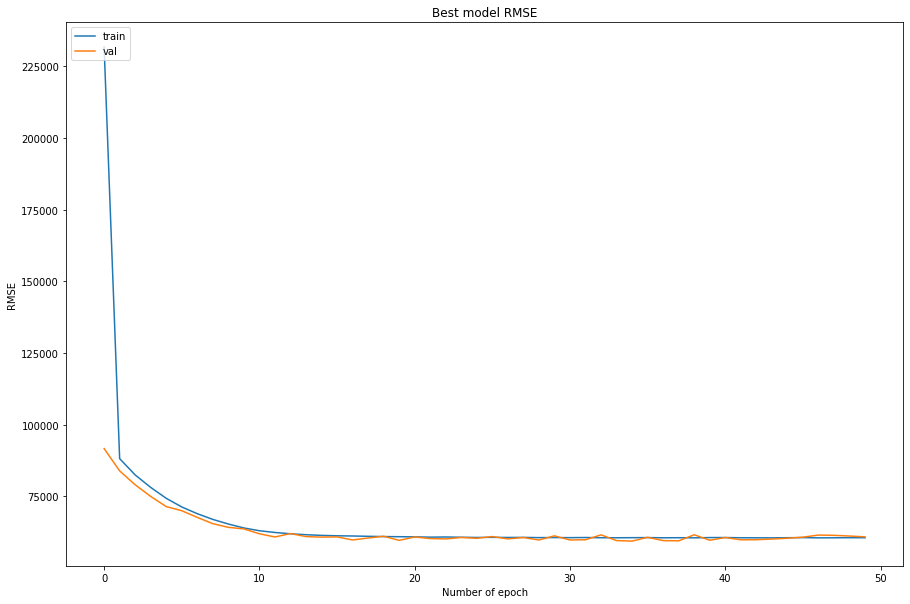

In [32]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot 
plt.plot(square_roots(Q2_best_model_history['best_model'].history['loss'][0:]))
plt.plot(square_roots(Q2_best_model_history['best_model'].history['val_loss'][0:]))
plt.title('Best model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

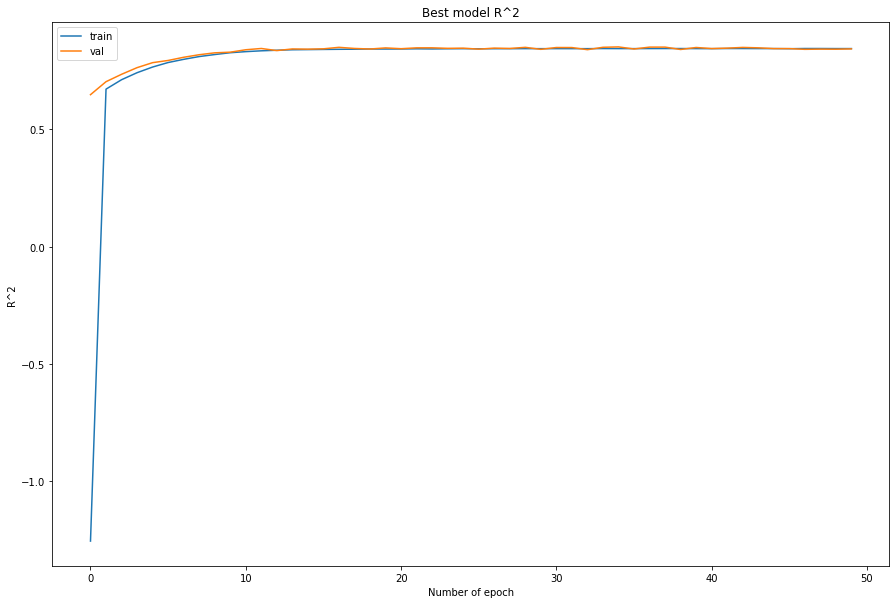

In [33]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot from the 6th epoch
plt.plot(Q2_best_model_history['best_model'].history['r2'][0:])
plt.plot(Q2_best_model_history['best_model'].history['val_r2'][0:])
plt.title('Best model R^2')
plt.ylabel('R^2')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

In [34]:
print("Train R^2 value: {}".format(Q2_best_model_history["best_model"].history["r2"][-1]))
print("Val R^2 value: {}".format(Q2_best_model_history["best_model"].history["val_r2"][-1]))

#Change it into a table
data = {"Train R^2": [Q2_best_model_history["best_model"].history["r2"][-1]],
        "Val R^2": [Q2_best_model_history["best_model"].history["val_r2"][-1]]}

R2_df = pd.DataFrame.from_dict(data)
R2_df

Train R^2 value: 0.8443395495414734
Val R^2 value: 0.8429989814758301


,Train R^2,Val R^2
0,0.84434,0.842999


In [45]:
data = { "Val_RMSE": square_roots(Q2_best_model_history['best_model'].history["val_loss"]),
         "Val_R^2": (Q2_best_model_history["best_model"].history["val_r2"])
        }

best_model_df = pd.DataFrame.from_dict(data)
best_model_df = best_model_df.sort_values(by='Val_RMSE', ascending=False)
best_model_df.head(30)

,Val_RMSE,Val_R^2
0,91632.255631,0.647879
1,83850.341347,0.703242
2,78996.891888,0.734740
3,74942.029009,0.763091
4,71385.007277,0.784330
5,69951.052144,0.793707
6,67620.164566,0.807276
7,65431.561314,0.818148
8,64146.943310,0.826187
9,63600.515218,0.829006


List down the trends

In [36]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(256)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(256)


In [46]:
old_test_loss, old_test_R2 = Q2_best_model.evaluate(Q3_old_test_ds)
print('Old Test RMSE: %f' % sqrt(old_test_loss))
print('Old Test R^2: %f' % old_test_R2)

new_test_2021_loss, new_test_2021_R2 = Q2_best_model.evaluate(Q3_new_test_2021_ds)
print('Test RMSE_2021: %f' % sqrt(new_test_2021_loss))
print('Test R^2_2021: %f' % (new_test_2021_R2))

new_test_2022_loss, new_test_2022_R2 = Q2_best_model.evaluate(Q3_new_test_2022_ds)
print('Test RMSE_2022: %f' % sqrt(new_test_2022_loss))
print('Test R^2_2022: %f' % (new_test_2022_R2))

#Output in a table

data = {"Old Test RMSE": [sqrt(old_test_loss)],
        "Old Test R^2": [(old_test_R2)],
        "Test RMSE_2021": [sqrt(new_test_2021_loss)],
        "Test R^2_2021": [(new_test_2021_R2)],
        "Test RMSE_2022": [(new_test_2022_loss)],
        "Test R^2_2022": [(new_test_2022_R2)]}

data_df = pd.DataFrame.from_dict(data)
data_df

131/131 [==============================] - 1s 6ms/step - loss: 6620967424.0000 - r2: 0.7423
Old Test RMSE: 81369.327292
Old Test R^2: 0.742261
114/114 [==============================] - 1s 6ms/step - loss: 7841825280.0000 - r2: 0.7008
Test RMSE_2021: 88554.081103
Test R^2_2021: 0.700787
67/67 [==============================] - 0s 6ms/step - loss: 16453141504.0000 - r2: 0.4205
Test RMSE_2022: 128269.799657
Test R^2_2022: 0.420473


,Old Test RMSE,Old Test R^2,Test RMSE_2021,Test R^2_2021,Test RMSE_2022,Test R^2_2022
0,81369.327292,0.742261,88554.081103,0.700787,1.645314e+10,0.420473


Q3b) Compare the extent to which model degradation has impacted your model to that of the team's linear regression model and explain why this has occured.



Q3C

Identifying Covariate shift 

In [47]:
# As we used train_ds for best_model, we are going to use train_dataframe

train_df_shift = train_dataframe.copy()
Q3_old_test_df_shift = Q3_old_test_df.copy()
test_df_2021_shift = Q3_new_test_2021_df.copy()
test_df_2022_shift = Q3_new_test_2022_df.copy()

In [137]:
train_df_shift.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


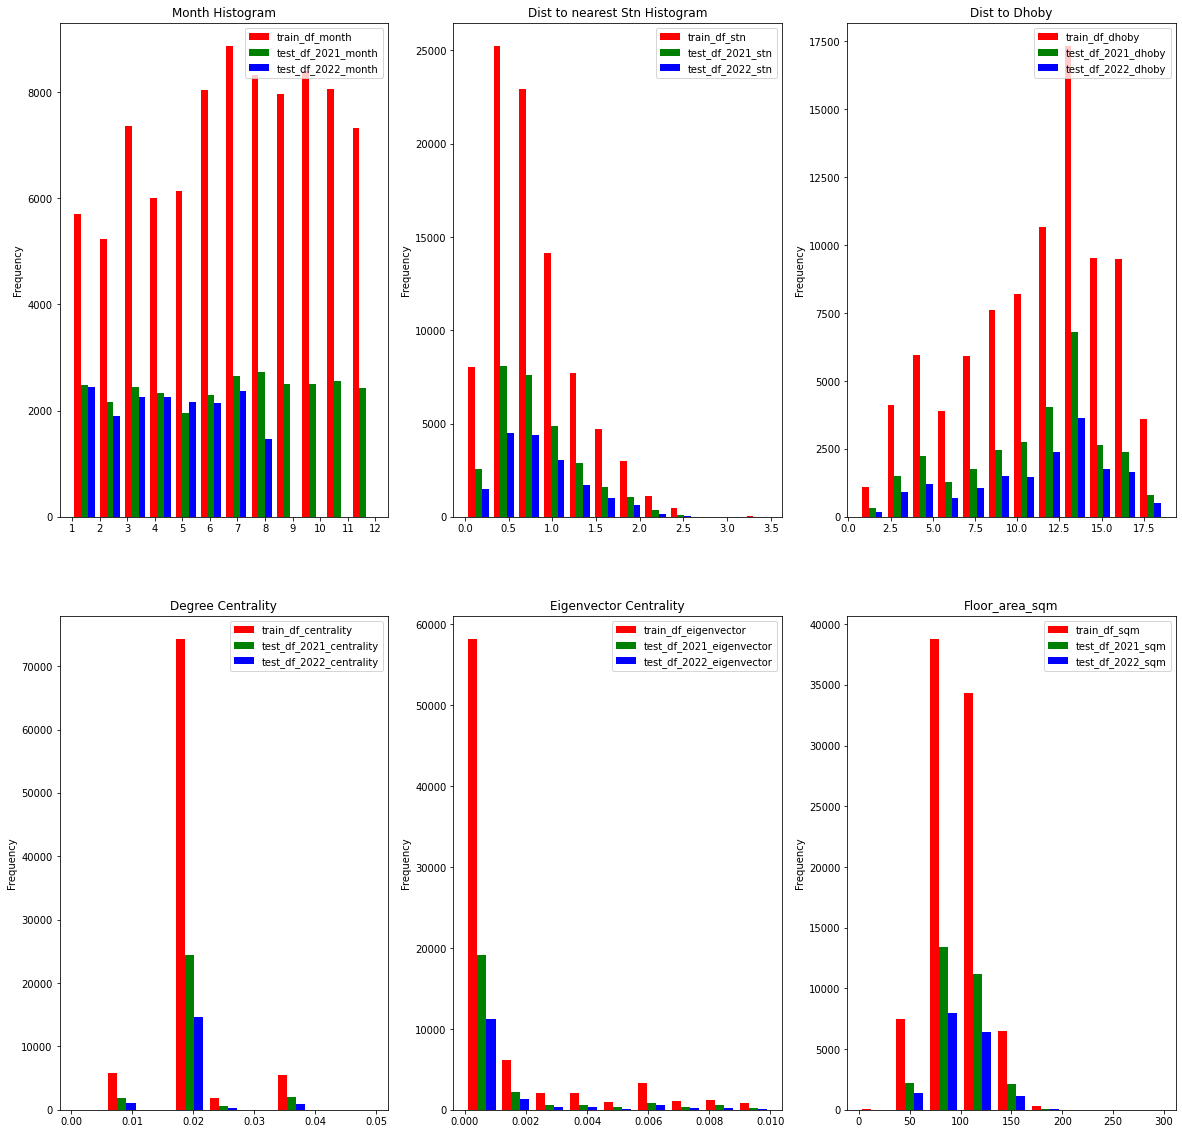

In [154]:
fig, axes =plt.subplots(2,3, figsize=(20,20))
axes[0][0].hist([train_df_shift["month"], test_df_2021_shift["month"],test_df_2022_shift["month"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_month', 'test_df_2021_month', 'test_df_2022_month'],rwidth=0.8)
axes[0][0].legend(loc='upper right')
axes[0][0].set_title('Month Histogram')
axes[0][0].set_xticks(range(1,13))
axes[0][0].set_ylabel('Frequency')

axes[0][1].hist([train_df_shift["dist_to_nearest_stn"], test_df_2021_shift["dist_to_nearest_stn"],test_df_2022_shift["dist_to_nearest_stn"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_stn', 'test_df_2021_stn', 'test_df_2022_stn'],rwidth=0.8)
axes[0][1].legend(loc='upper right')
axes[0][1].set_title('Dist to nearest Stn Histogram')
axes[0][1].set_ylabel('Frequency')


axes[0][2].hist([train_df_shift["dist_to_dhoby"], test_df_2021_shift["dist_to_dhoby"],test_df_2022_shift["dist_to_dhoby"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_dhoby', 'test_df_2021_dhoby', 'test_df_2022_dhoby'],rwidth=0.8)
axes[0][2].legend(loc='upper right')
axes[0][2].set_title('Dist to Dhoby')
axes[0][2].set_ylabel('Frequency')


axes[1][0].hist([train_df_shift["degree_centrality"], test_df_2021_shift["degree_centrality"],test_df_2022_shift["degree_centrality"]],bins = np.linspace(0, 0.05, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_centrality', 'test_df_2021_centrality', 'test_df_2022_centrality'],rwidth=0.8)
axes[1][0].legend(loc='upper right')
axes[1][0].set_title('Degree Centrality')
axes[1][0].set_ylabel('Frequency')

axes[1][1].hist([train_df_shift["eigenvector_centrality"], test_df_2021_shift["eigenvector_centrality"],test_df_2022_shift["eigenvector_centrality"]],bins = np.linspace(0, 0.01, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_eigenvector', 'test_df_2021_eigenvector', 'test_df_2022_eigenvector'],rwidth=0.8)
axes[1][1].legend(loc='upper right')
axes[1][1].set_title('Eigenvector Centrality')
axes[1][1].set_ylabel('Frequency')

axes[1][2].hist([train_df_shift["floor_area_sqm"], test_df_2021_shift["floor_area_sqm"],test_df_2022_shift["floor_area_sqm"]],bins = np.linspace(0, 300, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_sqm', 'test_df_2021_sqm', 'test_df_2022_sqm'],rwidth=0.8)
axes[1][2].legend(loc='upper right')
axes[1][2].set_title('Floor_area_sqm')
axes[1][2].set_ylabel('Frequency')
plt.show()

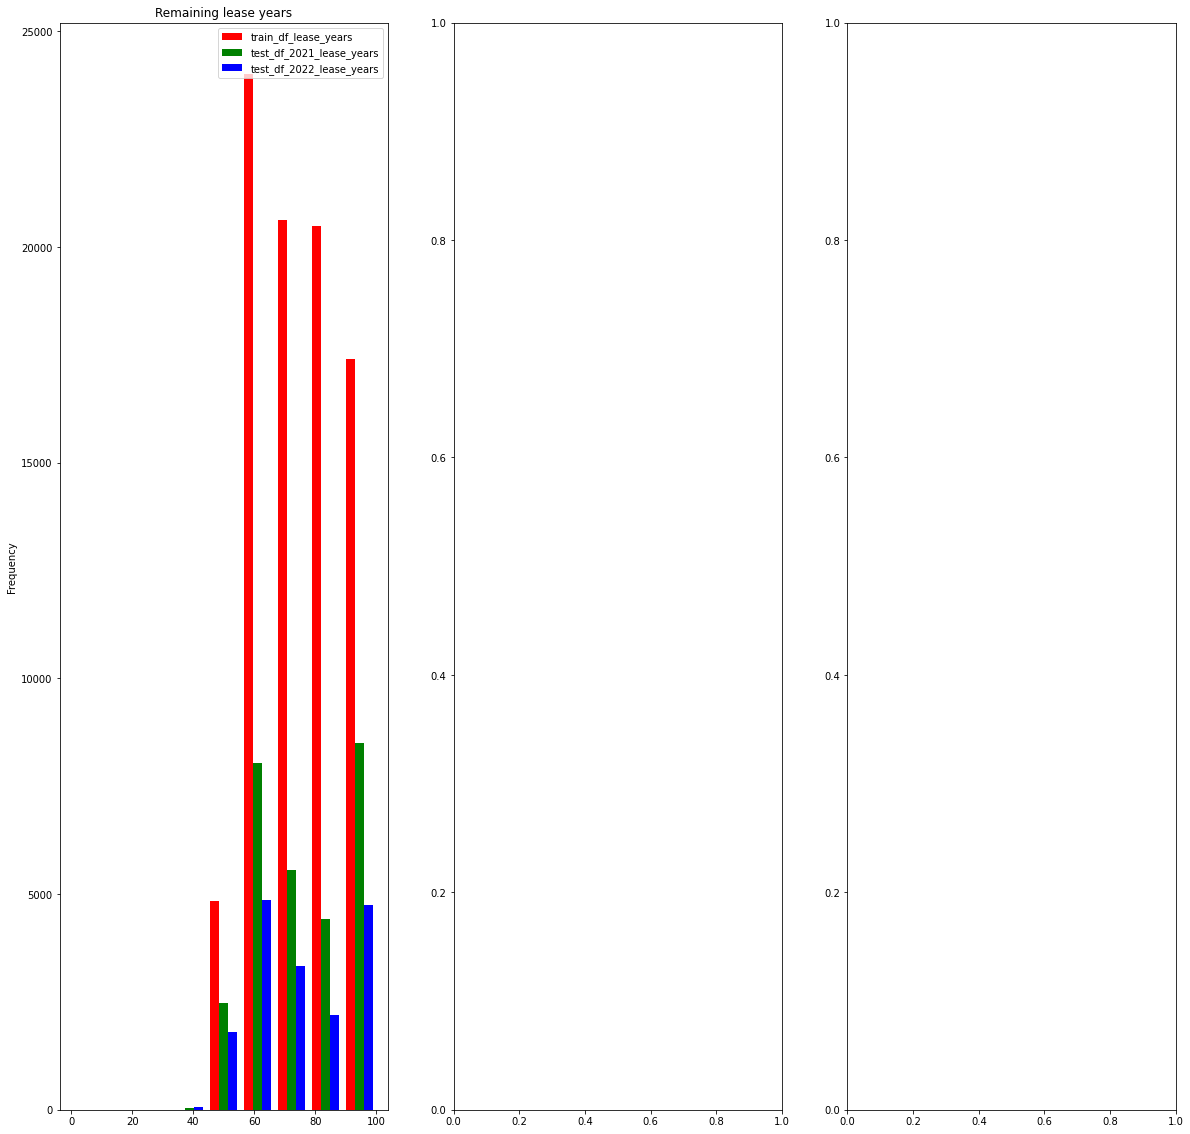

In [161]:
fig, axes =plt.subplots(1,3, figsize=(20,20))

axes[0].hist([train_df_shift["remaining_lease_years"], test_df_2021_shift["remaining_lease_years"],test_df_2022_shift["remaining_lease_years"]],bins = np.linspace(0, 100, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_lease_years', 'test_df_2021_lease_years', 'test_df_2022_lease_years'],rwidth=0.8)
axes[0].legend(loc='upper right')
axes[0].set_title('Remaining lease years')
axes[0].set_ylabel('Frequency')

# axes[1].hist([train_df_shift["storey_range"], test_df_2021_shift["storey_range"],test_df_2022_shift["storey_range"]],bins = 6, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_storey_range', 'test_df_2021_storey_range', 'test_df_2022_storey_range'],rwidth=0.8)
# axes[1].legend(loc='upper right')
# axes[1].set_title('Storey range')
# axes[1].set_ylabel('Frequency')

# axes[2].hist([train_df_shift["flat_model_type"], test_df_2021_shift["flat_model_type"],test_df_2022_shift["flat_model_type"]],bins = 6, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_flat_model', 'test_df_2021_flat_model', 'test_df_2022_flat_model'],rwidth=0.8)
# axes[2].legend(loc='upper right')
# axes[2].set_title('Flat model type')
# axes[2].set_ylabel('Frequency')
plt.show()

Q3C) Which variable showed the largest covariate/label shift that might have led to the drop in model performance as seen in 3b? 

**From the histogram plot, the floor sqm has the largest distribution shift within the train and test dataset which could be the reason for the drop in R^2 values
  The easiest way would be to plot the
**